In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from scipy import sparse
from sklearn.feature_extraction import FeatureHasher
from scipy.sparse import coo_matrix,csr_matrix,csc_matrix, hstack
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from sklearn import linear_model
import gc
from sklearn import preprocessing

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
%ls

1.5_create_lag.ipynb              preprocessed_products.csv
1_predata.ipynb                   RF_model/
1_predata_whole.ipynb             ruta_for_cliente_producto.csv
3_xgb_43fea.ipynb                 stack_sub/
3_xgb.ipynb                       submission_10_new.csv
3_xgb_prediction.ipynb            submission_11_new.csv
3_xgb_test.ipynb                  submission_44fea.csv
4_keras_nn.ipynb                  submission_all_train.csv
5_random_forest.ipynb             submission_nn.csv
6_stack_model.ipynb               submission_nn_xgb
7_SGD_regressor.ipynb             train_pivot_45678_to_9_whole_zero.csv
8_svm_linearSVR.ipynb             train_pivot_56789_to_10_44fea.pickle
agencia_for_cliente_producto.csv  train_pivot_56789_to_10_44fea_zero.pickle
bst_use_all_train.model           train_pivot_56789_to_10_new.pickle
canal_for_cliente_producto.csv    train_pivot_6789_to_11_new.pickle
old_submission/                   train_pivot_xgb_time1_44fea.csv
origin/                           t

### begin training, for week 11
----------------

In [18]:
predictors_target_11 = ['LR_prod', 'LR_prod_corr',
       'NombreCliente',
       'agen_cliente_for_log_de', 'agen_for_log_de',
       'agen_producto_for_log_de', 'agen_ruta_for_log_de',
       'cliente_for_log_de', 'cliente_for_log_sum',
       'cliente_producto_for_log_de', 'corr', 'pieces',
       'producto_for_log_de', 'ruta_cliente_for_log_de', 'ruta_for_log_de',
       'ruta_producto_for_log_de', 't2_min_t3', 't2_min_t4', 't2_min_t5',
       't3_min_t4', 't3_min_t5', 't4_min_t5', 't_m_2_cum', 't_m_3_cum',
       't_m_4_cum', 't_m_5_cum', 't_min_2', 't_min_3', 't_min_4',
       't_min_5', 'target', 'weight', 'weight_per_piece']

In [19]:
predictors_11 = ['LR_prod', 'LR_prod_corr',
       'NombreCliente',
       'agen_cliente_for_log_de', 'agen_for_log_de',
       'agen_producto_for_log_de', 'agen_ruta_for_log_de',
       'cliente_for_log_de', 'cliente_for_log_sum',
       'cliente_producto_for_log_de', 'corr', 'pieces',
       'producto_for_log_de', 'ruta_cliente_for_log_de', 'ruta_for_log_de',
       'ruta_producto_for_log_de', 't2_min_t3', 't2_min_t4', 't2_min_t5',
       't3_min_t4', 't3_min_t5', 't4_min_t5', 't_m_2_cum', 't_m_3_cum',
       't_m_4_cum', 't_m_5_cum', 't_min_2', 't_min_3', 't_min_4',
       't_min_5', 'weight', 'weight_per_piece']

In [10]:
f = lambda x : (x-x.mean())/x.std(ddof=0)

In [14]:
train_pivot_xgb_time2 = pd.read_csv('train_pivot_xgb_time2.csv',index_col = 0)

In [7]:
train_pivot_6789_to_11 = pd.read_pickle('train_pivot_6789_to_11_new.pickle')

In [8]:
train_pivot_xgb_time2.head()

,Agencia_ID,Canal_ID,Cliente_ID,LR_prod,LR_prod_corr,NombreCliente,Producto_ID,Ruta_SAK,agen_cliente_for_log_de,agen_for_log_de,...,t_m_3_cum,t_m_4_cum,t_m_5_cum,t_min_2,t_min_3,t_min_4,t_min_5,target,weight,weight_per_piece
0,2061,2,26,2.001190,7.293554,18434,1182,7212,2.852285,3.491654,...,NaN,NaN,3.688879,NaN,NaN,NaN,3.688879,0.000000,210.0,210.00
1,2061,2,26,1.839411,6.703932,18434,4767,7212,2.852285,3.491654,...,NaN,NaN,3.761200,NaN,NaN,NaN,3.761200,3.761200,250.0,NaN
2,2061,2,26,1.911283,6.965878,18434,31393,7212,2.852285,3.491654,...,8.650325,5.877736,3.044522,2.772589,2.772589,2.833213,3.044522,3.135494,640.0,NaN
3,2061,2,26,3.113374,11.347029,18434,34204,7212,2.852285,3.491654,...,11.024839,7.218177,3.784190,3.555348,3.806662,3.433987,3.784190,3.828641,450.0,56.25
4,2061,2,26,2.031231,7.403043,18434,34206,7212,2.852285,3.491654,...,12.963710,9.202510,4.795791,4.248495,3.761200,4.406719,4.795791,4.499810,340.0,42.50


In [15]:
train_pivot_xgb_time2.columns.values

array(['Agencia_ID', 'Canal_ID', 'Cliente_ID', 'LR_prod', 'LR_prod_corr',
       'NombreCliente', 'Producto_ID', 'Ruta_SAK',
       'agen_cliente_for_log_de', 'agen_for_log_de',
       'agen_producto_for_log_de', 'agen_ruta_for_log_de',
       'cliente_for_log_de', 'cliente_for_log_sum',
       'cliente_producto_for_log_de', 'corr', 'pieces',
       'producto_for_log_de', 'ruta_cliente_for_log_de', 'ruta_for_log_de',
       'ruta_producto_for_log_de', 't2_min_t3', 't2_min_t4', 't2_min_t5',
       't3_min_t4', 't3_min_t5', 't4_min_t5', 't_m_2_cum', 't_m_3_cum',
       't_m_4_cum', 't_m_5_cum', 't_min_2', 't_min_3', 't_min_4',
       't_min_5', 'target', 'weight', 'weight_per_piece'], dtype=object)

In [4]:
def normalize_dataset(train_dataset,test_dataset):
    train_dataset_normalize = train_dataset[predictors_11].copy()
    train_dataset_normalize['label'] = 0    
    
    test_dataset_normalize = test_dataset[predictors_11].copy()
    test_dataset_normalize['label'] = 1
    
    whole_dataset = pd.concat([train_dataset_normalize,test_dataset_normalize])
    whole_dataset_normalize = whole_dataset.apply(f,axis = 0)
    
    train_dataset_normalize = whole_dataset_normalize.loc[whole_dataset['label'] == 0]
    test_dataset_normalize = whole_dataset_normalize.loc[whole_dataset['label']==1]
    
    train_dataset_normalize.drop(['label'],axis = 1,inplace = True)
    test_dataset_normalize.drop(['label'],axis =1,inplace = True)
    
    train_dataset_normalize['target'] = train_dataset['target'].copy() 
    
#     target = train_dataset['target']
    return train_dataset_normalize,test_dataset_normalize

In [21]:
train_dataset_normalize, test_dataset_normalize = normalize_dataset(train_pivot_xgb_time2,train_pivot_6789_to_11)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
train_dataset_normalize.head()

Semana,LR_prod,LR_prod_corr,NombreCliente,agen_cliente_for_log_de,agen_for_log_de,agen_producto_for_log_de,agen_ruta_for_log_de,cliente_for_log_de,cliente_for_log_sum,cliente_producto_for_log_de,...,t_m_3_cum,t_m_4_cum,t_m_5_cum,t_min_2,t_min_3,t_min_4,t_min_5,weight,weight_per_piece,target
0,0.440004,0.007984,-1.198863,2.893915,7.040262,4.922515,3.707101,2.951726,0.023732,2.468511,...,NaN,NaN,0.841755,NaN,NaN,NaN,2.148223,0.041948,0.552880,0.000000
1,0.136858,0.004843,-1.198863,2.893915,7.040262,4.561988,3.707101,2.951726,0.023732,2.558317,...,NaN,NaN,0.888582,NaN,NaN,NaN,2.230611,0.180385,NaN,3.761200
2,0.271533,0.006239,-1.198863,2.893915,7.040262,3.000979,3.707101,2.951726,0.023732,1.433925,...,1.028141,0.851082,0.424536,1.090852,1.086921,1.149949,1.414172,1.530144,NaN,3.135494
3,2.524041,0.029578,-1.198863,2.893915,7.040262,3.917930,3.707101,2.951726,0.023732,2.414081,...,1.752516,1.424506,0.903467,1.968861,2.245187,1.825675,2.256800,0.872569,-0.290791,3.828641
4,0.496296,0.008568,-1.198863,2.893915,7.040262,5.719378,3.707101,2.951726,0.023732,3.231175,...,2.343992,2.273380,1.558475,2.746354,2.194265,2.919764,3.409216,0.491868,-0.366242,4.499810


In [26]:
train_pivot_xgb_time2_sample = train_dataset_normalize.sample(2000000)

train_feature_11 = train_pivot_xgb_time2_sample.drop(['target'],axis = 1)
train_label_11 = train_pivot_xgb_time2_sample[['target']]

dtrain_11 = xgb.DMatrix(train_feature_11,label = train_label_11,missing=np.nan)

In [27]:
num_round = 1000

cvresult = xgb.cv(param_11, dtrain_11, num_round, nfold=5,verbose_eval = 1,show_stdv=False,
                        seed = 0, early_stopping_rounds=5)
print(cvresult.tail())

[0]	train-rmse:1.14019	test-rmse:1.14021
[1]	train-rmse:0.961458	test-rmse:0.961473
[2]	train-rmse:0.824843	test-rmse:0.824873
[3]	train-rmse:0.722328	test-rmse:0.722397
[4]	train-rmse:0.647489	test-rmse:0.647603
[5]	train-rmse:0.592862	test-rmse:0.593041
[6]	train-rmse:0.555021	test-rmse:0.555254
[7]	train-rmse:0.528662	test-rmse:0.528924
[8]	train-rmse:0.510662	test-rmse:0.510977
[9]	train-rmse:0.498551	test-rmse:0.498903
[10]	train-rmse:0.49003	test-rmse:0.490423
[11]	train-rmse:0.484163	test-rmse:0.484588
[12]	train-rmse:0.480003	test-rmse:0.480457
[13]	train-rmse:0.477039	test-rmse:0.47752
[14]	train-rmse:0.474897	test-rmse:0.475405
[15]	train-rmse:0.473305	test-rmse:0.473844
[16]	train-rmse:0.472061	test-rmse:0.472641
[17]	train-rmse:0.471142	test-rmse:0.471752
[18]	train-rmse:0.470369	test-rmse:0.471
[19]	train-rmse:0.469729	test-rmse:0.470375
[20]	train-rmse:0.469123	test-rmse:0.469783
[21]	train-rmse:0.468683	test-rmse:0.469369
[22]	train-rmse:0.468239	test-rmse:0.468944
[23]	

In [24]:
param_11 = {'booster':'gbtree',
         'nthread': 10,
         'max_depth':5, 
         'eta':0.2,
         'silent':1,
         'subsample':0.7, 
         'objective':'reg:linear',
         'eval_metric':'rmse',
         'colsample_bytree':0.7}

In [28]:
num_round = 566

dtest_11 = xgb.DMatrix(test_dataset_normalize[predictors_11], missing=np.nan)
submission_11 = train_pivot_6789_to_11[['id']].copy()
j =0 
for j in range(20):
    
    train_pivot_xgb_time2_sample = train_dataset_normalize[predictors_target_11].sample(2000000)
    train_feature_11 = train_pivot_xgb_time2_sample.drop(['target'],axis = 1)
    train_label_11 = train_pivot_xgb_time2_sample[['target']]

    dtrain_11 = xgb.DMatrix(train_feature_11,label = train_label_11,missing= np.nan)
    
    bst_11 = xgb.train(param_11, dtrain_11, num_round)
    print str(j) + 'training finished!'
    submission_11['predict_' + str(j)] = bst_11.predict(dtest_11)

print 'finished'

0training finished!
1training finished!
2training finished!
3training finished!
4training finished!
5training finished!
6training finished!
7training finished!
8training finished!
9training finished!
10training finished!
11training finished!
12training finished!
13training finished!
14training finished!
15training finished!
16training finished!
17training finished!
18training finished!
19training finished!
finished


In [12]:
# make prediction
dtest_11 = xgb.DMatrix(train_pivot_6789_to_11[predictors], missing=NaN)
submission_11 = train_pivot_6789_to_11[['id']].copy()
submission_11['predict'] = bst.predict(dtest)
xgb.plot_importance(bst)

In [29]:
submission_11.to_csv('submission_11_new.csv')

In [11]:
submission_11 = pd.read_csv('submission_11_new.csv',index_col =0)

In [12]:
submission_11.columns.values

array(['id', 'predict_0', 'predict_1', 'predict_2', 'predict_3',
       'predict_4', 'predict_5', 'predict_6', 'predict_7', 'predict_8',
       'predict_9', 'predict_10', 'predict_11', 'predict_12', 'predict_13',
       'predict_14', 'predict_15', 'predict_16', 'predict_17',
       'predict_18', 'predict_19'], dtype=object)

### for week 10
-------

In [2]:
%ls

1.5_create_lag.ipynb              preprocessed_products.csv
1_predata.ipynb                   RF_model/
1_predata_whole.ipynb             ruta_for_cliente_producto.csv
3_xgb_43fea.ipynb                 stack_sub/
3_xgb.ipynb                       submission_10_new.csv
3_xgb_prediction.ipynb            submission_11_new.csv
3_xgb_test.ipynb                  submission_44fea.csv
4_keras_nn.ipynb                  submission_all_train.csv
5_random_forest.ipynb             submission_nn.csv
6_stack_model.ipynb               submission_nn_xgb
7_SGD_regressor.ipynb             train_pivot_56789_to_10_44fea.pickle
8_svm_linearSVR.ipynb             train_pivot_56789_to_10_44fea_zero.pickle
agencia_for_cliente_producto.csv  train_pivot_56789_to_10_new.pickle
bst_use_all_train.model           train_pivot_6789_to_11_new.pickle
canal_for_cliente_producto.csv    train_pivot_xgb_time1_44fea.csv
old_submission/                   train_pivot_xgb_time1_44fea_zero.csv
origin/                           tr

In [4]:
predictors_target_10 = ['ruta_freq', 'clien_freq', 'agen_freq', 'prod_freq',
       'agen_for_log_de', 'ruta_for_log_de', 'cliente_for_log_de',
       'producto_for_log_de', 'agen_ruta_for_log_de',
       'agen_cliente_for_log_de', 'agen_producto_for_log_de',
       'ruta_cliente_for_log_de', 'ruta_producto_for_log_de',
       'cliente_producto_for_log_de', 'cliente_for_log_sum',
       'cliente_producto_agen_for_log_sum', 'corr', 't_min_1', 't_min_2',
       't_min_3', 't_min_4', 't_min_5', 't1_min_t2', 't1_min_t3',
       't1_min_t4', 't1_min_t5', 't2_min_t3', 't2_min_t4', 't2_min_t5',
       't3_min_t4', 't3_min_t5', 't4_min_t5', 'LR_prod', 'LR_prod_corr',
       'target', 't_m_5_cum', 't_m_4_cum', 't_m_3_cum', 't_m_2_cum',
       't_m_1_cum', 'NombreCliente', 'weight', 'weight_per_piece', 'pieces']

In [5]:
predictors_10 = ['ruta_freq', 'clien_freq', 'agen_freq', 'prod_freq',
       'agen_for_log_de', 'ruta_for_log_de', 'cliente_for_log_de',
       'producto_for_log_de', 'agen_ruta_for_log_de',
       'agen_cliente_for_log_de', 'agen_producto_for_log_de',
       'ruta_cliente_for_log_de', 'ruta_producto_for_log_de',
       'cliente_producto_for_log_de', 'cliente_for_log_sum',
       'cliente_producto_agen_for_log_sum', 'corr', 't_min_1', 't_min_2',
       't_min_3', 't_min_4', 't_min_5', 't1_min_t2', 't1_min_t3',
       't1_min_t4', 't1_min_t5', 't2_min_t3', 't2_min_t4', 't2_min_t5',
       't3_min_t4', 't3_min_t5', 't4_min_t5', 'LR_prod', 'LR_prod_corr',
       't_m_5_cum', 't_m_4_cum', 't_m_3_cum', 't_m_2_cum',
       't_m_1_cum', 'NombreCliente', 'weight', 'weight_per_piece', 'pieces']

In [28]:
def normalize_dataset_10(train_dataset,test_dataset):
    train_dataset_normalize = train_dataset[predictors_10].copy()
    train_dataset_normalize['label'] = 0    
    
    test_dataset_normalize = test_dataset[predictors_10].copy()
    test_dataset_normalize['label'] = 1
    
    whole_dataset = pd.concat([train_dataset_normalize,test_dataset_normalize],copy = False)
    whole_dataset_normalize = whole_dataset.apply(f,axis = 0)
    
    train_dataset_normalize = whole_dataset_normalize.loc[whole_dataset['label'] == 0]
    test_dataset_normalize = whole_dataset_normalize.loc[whole_dataset['label']==1]
    
    train_dataset_normalize.drop(['label'],axis = 1,inplace = True)
    test_dataset_normalize.drop(['label'],axis =1,inplace = True)
    
    train_dataset_normalize['target'] = train_dataset['target'].copy() 
    test_dataset_normalize['id'] = test_dataset['id'].copy() 

    
#     target = train_dataset['target']
    return train_dataset_normalize,test_dataset_normalize

In [29]:
f = lambda x : (x-x.mean())/x.std(ddof=0)

In [6]:
train_pivot_xgb_time1 = pd.read_csv('train_pivot_45678_to_9_whole_zero.csv',
                                     dtype=np.float32,usecols = predictors_target_10)

In [19]:
train_pivot_56789_to_10 = pd.read_pickle('train_pivot_56789_to_10_44fea_zero.pickle')

In [20]:
train_pivot_56789_to_10['id'] = train_pivot_56789_to_10['id'].astype(int)
train_pivot_56789_to_10.head()

Semana,id,ruta_freq,clien_freq,agen_freq,prod_freq,agen_for_log_de,ruta_for_log_de,cliente_for_log_de,producto_for_log_de,agen_ruta_for_log_de,...,LR_prod_corr,t_m_5_cum,t_m_4_cum,t_m_3_cum,t_m_2_cum,t_m_1_cum,NombreCliente,weight,weight_per_piece,pieces
0,1569352,10.0,166.0,3604.0,143.0,4.001407,3.411275,2.890955,2.498162,3.411275,...,0.106650,0.000000,0.000000,0.000000,0.000000,0.000000,131.0,691.0,NaN,NaN
1,6667200,713.0,166.0,12208.0,10842.0,3.523074,3.222417,2.890955,4.361940,2.835826,...,21.111349,3.784190,7.280697,10.714684,14.403563,18.092443,6027.0,740.0,NaN,NaN
2,1592616,713.0,166.0,12208.0,10780.0,3.523074,3.222417,2.890955,3.987424,2.835826,...,19.113272,0.000000,2.833213,6.165418,8.730368,11.949243,6027.0,480.0,NaN,NaN
3,3909690,713.0,166.0,12208.0,13222.0,3.523074,3.222417,2.890955,4.529289,2.835826,...,21.542048,4.430817,8.144389,12.461877,16.556221,20.886955,6027.0,680.0,NaN,NaN
4,3659672,713.0,166.0,12208.0,10881.0,3.523074,3.222417,2.890955,3.238592,2.835826,...,14.471490,3.583519,7.138867,10.827746,14.656388,18.319950,6027.0,567.0,NaN,NaN


In [6]:
train_pivot_56789_to_10.columns.values

array(['id', 'ruta_freq', 'clien_freq', 'agen_freq', 'prod_freq',
       'agen_for_log_de', 'ruta_for_log_de', 'cliente_for_log_de',
       'producto_for_log_de', 'agen_ruta_for_log_de',
       'agen_cliente_for_log_de', 'agen_producto_for_log_de',
       'ruta_cliente_for_log_de', 'ruta_producto_for_log_de',
       'cliente_producto_for_log_de', 'cliente_for_log_sum',
       'cliente_producto_agen_for_log_sum', 'corr', 't_min_1', 't_min_2',
       't_min_3', 't_min_4', 't_min_5', 't1_min_t2', 't1_min_t3',
       't1_min_t4', 't1_min_t5', 't2_min_t3', 't2_min_t4', 't2_min_t5',
       't3_min_t4', 't3_min_t5', 't4_min_t5', 'LR_prod', 'LR_prod_corr',
       't_m_5_cum', 't_m_4_cum', 't_m_3_cum', 't_m_2_cum', 't_m_1_cum',
       'NombreCliente', 'weight', 'weight_per_piece', 'pieces'], dtype=object)

In [7]:
train_pivot_xgb_time1.columns.values

array(['ruta_freq', 'clien_freq', 'agen_freq', 'prod_freq',
       'agen_for_log_de', 'ruta_for_log_de', 'cliente_for_log_de',
       'producto_for_log_de', 'agen_ruta_for_log_de',
       'agen_cliente_for_log_de', 'agen_producto_for_log_de',
       'ruta_cliente_for_log_de', 'ruta_producto_for_log_de',
       'cliente_producto_for_log_de', 'cliente_for_log_sum',
       'cliente_producto_agen_for_log_sum', 'corr', 't_min_1', 't_min_2',
       't_min_3', 't_min_4', 't_min_5', 't1_min_t2', 't1_min_t3',
       't1_min_t4', 't1_min_t5', 't2_min_t3', 't2_min_t4', 't2_min_t5',
       't3_min_t4', 't3_min_t5', 't4_min_t5', 'LR_prod', 'LR_prod_corr',
       'target', 't_m_5_cum', 't_m_4_cum', 't_m_3_cum', 't_m_2_cum',
       't_m_1_cum', 'NombreCliente', 'weight', 'weight_per_piece', 'pieces'], dtype=object)

### begin xgboost
------------------------

In [9]:
%ls

1.5_create_lag.ipynb              pivot_train_with_nan.pickle
1_predata.ipynb                   preprocessed_products.csv
1_predata_whole.ipynb             RF_model/
3_xgb_43fea.ipynb                 ruta_for_cliente_producto.csv
3_xgb.ipynb                       stack_sub/
3_xgb_prediction.ipynb            submission_10_new.csv
3_xgb_test.ipynb                  submission_11_new.csv
4_keras_nn.ipynb                  submission_44fea.csv
5_random_forest.ipynb             submission_all_train_10.csv
6_stack_model.ipynb               submission_all_train_11.csv
7_SGD_regressor.ipynb             submission_all_train_12.csv
8_svm_linearSVR.ipynb             submission_all_train_13.csv
9_private_board.ipynb             submission_all_train_14.csv
agencia_for_cliente_producto.csv  submission_all_train_2.csv
bst_1000_eta001_2.model           submission_all_train_3.csv
bst_1000_eta001.model             submission_all_train_4.csv
bst_1000_eta002.model             submission_all_train_5.csv
bst_

In [38]:
#right now the best is this parameter set with 700 round
param_10 = {'booster':'gbtree',
         'nthread': 12,
         'max_depth':8, 
         'eta':0.1,
         'silent':1,
         'subsample':0.5, 
         'objective':'reg:linear',
         'eval_metric':'rmse',
         'colsample_bytree':0.7}

In [10]:
train_feature_10 = train_pivot_xgb_time1.drop(['target'],axis = 1)
train_label_10 = train_pivot_xgb_time1['target']

dtrain_10 = xgb.DMatrix(train_feature_10,label = train_label_10,missing= np.nan)

In [11]:
bst = xgb.Booster({'nthread':8}) #init model
bst.load_model("bst_1400_eta0015.model") # load data

In [67]:
bst

In [21]:
dtest_10 = xgb.DMatrix(train_pivot_56789_to_10.drop(['id'],axis =1), missing=np.nan)

In [35]:
submission_10_all_train = pd.DataFrame()
submission_10_all_train = train_pivot_56789_to_10[['id']].copy()
submission_10_all_train['predict'] = bst.predict(dtest_10)
submission_10_all_train.reset_index(drop = True,inplace = True)

In [36]:
submission_10_all_train.to_csv('week10_private2.csv',index = False)

In [37]:
submission_10_all_train['predict'].describe()

count    3.538385e+06
mean     1.573562e+00
std      7.086894e-01
min     -3.240995e-01
25%      1.061112e+00
50%      1.408914e+00
75%      1.898488e+00
max      7.382428e+00
Name: predict, dtype: float64

In [14]:
submission_10_all_train.head()

Semana,id,predict
0,1569352,2.389577
1,6667200,3.532464
2,1592616,2.962314
3,3909690,4.135859
4,3659672,3.563721


In [15]:
submission_10_all_train.to_csv('week10_private.csv')

In [33]:
num_round = 1600
evallist = [(dtrain_10,'train')]
bst = xgb.train(param_10, dtrain_10, num_round,evallist)

[0]	train-rmse:1.35052
[1]	train-rmse:1.33273
[2]	train-rmse:1.31522
[3]	train-rmse:1.29818
[4]	train-rmse:1.2813
[5]	train-rmse:1.26485
[6]	train-rmse:1.24863
[7]	train-rmse:1.23255
[8]	train-rmse:1.21692
[9]	train-rmse:1.20137
[10]	train-rmse:1.18612
[11]	train-rmse:1.17115
[12]	train-rmse:1.1564
[13]	train-rmse:1.1419
[14]	train-rmse:1.12764
[15]	train-rmse:1.11363
[16]	train-rmse:1.09985
[17]	train-rmse:1.08633
[18]	train-rmse:1.07303
[19]	train-rmse:1.05999
[20]	train-rmse:1.04719
[21]	train-rmse:1.03474
[22]	train-rmse:1.02235
[23]	train-rmse:1.01018
[24]	train-rmse:0.998356
[25]	train-rmse:0.986818
[26]	train-rmse:0.975354
[27]	train-rmse:0.964049
[28]	train-rmse:0.952932
[29]	train-rmse:0.942135
[30]	train-rmse:0.93145
[31]	train-rmse:0.92095
[32]	train-rmse:0.910629
[33]	train-rmse:0.900503
[34]	train-rmse:0.890605
[35]	train-rmse:0.880889
[36]	train-rmse:0.871322
[37]	train-rmse:0.861935
[38]	train-rmse:0.852721
[39]	train-rmse:0.843735
[40]	train-rmse:0.834869
[41]	train-rms

In [34]:
bst.save_model('bst_1600_eta0015.model')

### begin cv
------------

In [10]:
gc.collect()

16

In [32]:
#right now the best is this parameter set with 700 round
param_10 = {'booster':'gbtree',
         'nthread': 8,
         'max_depth':8, 
         'eta':0.015,
         'silent':1,
         'subsample':0.5, 
         'objective':'reg:linear',
         'eval_metric':'rmse',
         'colsample_bytree':0.5}

In [149]:
num_round = 400

cvresult = xgb.cv(param_10, dtrain_10, num_round, nfold=4,show_stdv=False,
                        seed = 0, early_stopping_rounds=5,verbose_eval = 1)
print(cvresult.tail())

[0]	train-rmse:1.34436	test-rmse:1.34436
[1]	train-rmse:1.32079	test-rmse:1.32079
[2]	train-rmse:1.29786	test-rmse:1.29787
[3]	train-rmse:1.27532	test-rmse:1.27533
[4]	train-rmse:1.2535	test-rmse:1.2535
[5]	train-rmse:1.2321	test-rmse:1.23211
[6]	train-rmse:1.21113	test-rmse:1.21114
[7]	train-rmse:1.19076	test-rmse:1.19077
[8]	train-rmse:1.17074	test-rmse:1.17076
[9]	train-rmse:1.15127	test-rmse:1.15128
[10]	train-rmse:1.13219	test-rmse:1.13221
[11]	train-rmse:1.11348	test-rmse:1.1135
[12]	train-rmse:1.09533	test-rmse:1.09535
[13]	train-rmse:1.07753	test-rmse:1.07755
[14]	train-rmse:1.06016	test-rmse:1.06018
[15]	train-rmse:1.04318	test-rmse:1.04321
[16]	train-rmse:1.02652	test-rmse:1.02655
[17]	train-rmse:1.01034	test-rmse:1.01037
[18]	train-rmse:0.994443	test-rmse:0.994482
[19]	train-rmse:0.978944	test-rmse:0.978986
[20]	train-rmse:0.963866	test-rmse:0.96391
[21]	train-rmse:0.949097	test-rmse:0.949142
[22]	train-rmse:0.934742	test-rmse:0.93479
[23]	train-rmse:0.920769	test-rmse:0.920

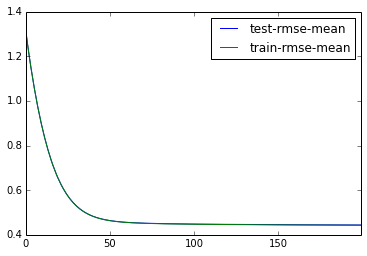

In [83]:
cvresult[['test-rmse-mean','train-rmse-mean']].plot()

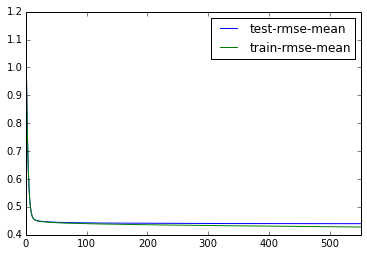

In [72]:
cvresult[['test-rmse-mean','train-rmse-mean']].plot()

In [79]:
curve_all = cvresult[['test-rmse-mean','train-rmse-mean']].copy()

- 287: 0.452760, max_depth: 5, nthread = 1
- 771 : 0.445958, max_depth: 5, nthread = 12
- 429 : 0.445676, max_depth: 6
- 348 : 0.445456, max_depth:7
- 348 : 0.445216, max_depth:8


### begin combine for all train model
--------------------------------------

In [24]:
submission_11 = pd.read_csv('submission_11_new.csv',index_col = 0)

In [25]:
submission_11.reset_index(inplace = True)
submission_11.head()

,id,predict
0,1547831,4.406201
1,6825659,3.053817
2,5853787,2.684612
3,2316053,1.259826
4,900676,2.301486


In [26]:
submission_all_train = pd.concat([submission_10_all_train,submission_11],axis =0)
submission_all_train['predict'] = submission_all_train['predict'].apply(np.expm1)
submission_all_train.rename(columns = {'predict':'Demanda_uni_equil'},inplace = True)
submission_all_train['Demanda_uni_equil'] = submission_all_train['Demanda_uni_equil'].round(1)

In [27]:
submission_all_train.loc[submission_all_train['Demanda_uni_equil']<0,'Demanda_uni_equil'] = 0

In [28]:
submission_all_train['Demanda_uni_equil'].describe()

count    6.999251e+06
mean     6.120201e+00
std      1.580884e+01
min      0.000000e+00
25%      1.900000e+00
50%      3.100000e+00
75%      5.700000e+00
max      2.598100e+03
Name: Demanda_uni_equil, dtype: float64

In [29]:
submission_all_train['id'] = submission_all_train['id'].astype(int)

In [30]:
submission_all_train.head()

Semana,id,Demanda_uni_equil
0,1569352,8.4
1,6667200,33.8
2,1592616,18.4
3,3909690,62.3
4,3659672,34.5


In [31]:
submission_all_train.to_csv('submission_all_train_15.csv',index = False)

In [136]:
%ls

1.5_create_lag.ipynb              pivot_test.pickle
1_predata.ipynb                   pivot_train_with_nan.pickle
1_predata_whole.ipynb             preprocessed_products.csv
3_xgb_43fea.ipynb                 RF_model/
3_xgb.ipynb                       ruta_for_cliente_producto.csv
3_xgb_prediction.ipynb            stack_sub/
3_xgb_test.ipynb                  submission_10_new.csv
4_keras_nn.ipynb                  submission_11_new.csv
5_random_forest.ipynb             submission_44fea.csv
6_stack_model.ipynb               submission_all_train_2.csv
7_SGD_regressor.ipynb             submission_all_train_3.csv
8_svm_linearSVR.ipynb             submission_all_train.csv
agencia_for_cliente_producto.csv  submission_nn.csv
bst_1000.model                    submission_nn_xgb
bst_1200_eta005.model             train_pivot_45678_to_9_whole_zero.csv
bst_200_eta005.model              train_pivot_56789_to_10_44fea.pickle
bst_400_eta005.model              train_pivot_56789_to_10_44fea_zero.pickle
bs

### begin cross validation

In [21]:
num_round = 392

dtest_10 = xgb.DMatrix(test_dataset_10_normalize[predictors_10], missing=np.nan)
submission_10 = train_pivot_56789_to_10[['id']].copy()
i = 0

for i in range(20):
    train_pivot_xgb_time1_sample = train_dataset_10_normalize[predictors_target_10].sample(2000000)

    train_feature_10 = train_pivot_xgb_time1_sample.drop(['target'],axis = 1)
    train_label_10 = train_pivot_xgb_time1_sample[['target']]

    dtrain_10 = xgb.DMatrix(train_feature_10,label = train_label_10,missing= np.nan)
    
    bst = xgb.train(param_10, dtrain_10, num_round)
    print str(i) + 'training finished!'
    submission_10['predict_' + str(i)] = bst.predict(dtest_10)
    print str(i) + 'predicting finished!'


print 'finished'

0training finished!
0predicting finished!
1training finished!
1predicting finished!
2training finished!
2predicting finished!
3training finished!
3predicting finished!
4training finished!
4predicting finished!
5training finished!
5predicting finished!
6training finished!
6predicting finished!
7training finished!
7predicting finished!
8training finished!
8predicting finished!
9training finished!
9predicting finished!
10training finished!
10predicting finished!
11training finished!
11predicting finished!
12training finished!
12predicting finished!
13training finished!
13predicting finished!
14training finished!
14predicting finished!
15training finished!
15predicting finished!
16training finished!
16predicting finished!
17training finished!
17predicting finished!
18training finished!
18predicting finished!
19training finished!
19predicting finished!
finished


In [22]:
submission_10.to_csv('submission_10_new.csv')

In [26]:
# make prediction
xgb.plot_importance(bst)

### result for 44fea
---------------

In [13]:
submission_11['predict'] = submission_11[['predict_' + str(i) for i in range(20)]].mean(axis=1)

In [14]:
submission_11 = submission_11[['id','predict']]
gc.collect()
submission_11.head()

,id,predict
0,1547831,4.406201
1,6825659,3.053817
2,5853787,2.684612
3,2316053,1.259826
4,900676,2.301486


In [24]:
submission_11.to_csv('submission_11_new.csv',index = False)

In [16]:
submission_44fea = pd.concat([submission_44fea,submission_11],axis =0,copy = False)

In [17]:
submission_44fea.shape

(6999251, 2)

In [18]:
submission_44fea.rename(columns = {'predict':'Demanda_uni_equil'},inplace = True)
submission_44fea['Demanda_uni_equil'] = submission_44fea['Demanda_uni_equil'].apply(np.expm1)
submission_44fea.head()

Semana,id,Demanda_uni_equil
0,1569352,10.206472
1,6667200,35.766411
2,1592616,17.642273
3,3909690,62.235741
4,3659672,34.847991


In [19]:
submission_44fea['Demanda_uni_equil'] = submission_44fea['Demanda_uni_equil'].round(1)

In [20]:
submission_44fea['Demanda_uni_equil'].describe()

count    6.999251e+06
mean     6.075400e+00
std      1.606870e+01
min     -7.000000e-01
25%      1.900000e+00
50%      3.100000e+00
75%      5.600000e+00
max      2.879800e+03
Name: Demanda_uni_equil, dtype: float64

In [21]:
mask = submission_44fea[submission_44fea['Demanda_uni_equil'] <= 0].index
submission_44fea.loc[mask,'Demanda_uni_equil'] = 0
submission_44fea['Demanda_uni_equil'].describe()

count    6.999251e+06
mean     6.074749e+00
std      1.606832e+01
min      0.000000e+00
25%      1.900000e+00
50%      3.100000e+00
75%      5.600000e+00
max      2.879800e+03
Name: Demanda_uni_equil, dtype: float64

In [22]:
submission_44fea.head()

Semana,id,Demanda_uni_equil
0,1569352,10.2
1,6667200,35.8
2,1592616,17.6
3,3909690,62.2
4,3659672,34.8


In [23]:
submission_44fea.to_csv('submission_44fea.csv',index = False)